### ***                 CHỦ ĐỀ:  ỨNG DỤNG MÔ HÌNH HỌC MÁY VÀO DỰ ĐOÁN SỐ ĐIỆN SỬ DỤNG TRONG THÁNG***


# Cách sử dụng trên Google Colab:

---




**Bước 1: Cài đặt kagglehub (chạy cell đầu tiên)**

**Bước 2: Xác thực Kaggle (Ở đây dataset ta chọn electric-power-consumption-data-set là public nên không cần xác thực)**

**Bước 3: Chạy các cell theo thứ tự**


---




In [63]:
#Cài đặt và import các thư viện cần thiết
!pip install kagglehub[pandas-datasets]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# **1. TIỀN XỬ LÝ DỮ LIỆU (PREPROCESSING)**

---


*1.1. Tải và Làm sạch dữ liệu*

---



In [64]:
# 1.1 Tải dữ liệu
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
df = pd.read_csv(f"{path}/household_power_consumption.txt", sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=False, na_values=['?'])
df.set_index('datetime', inplace=True)

# 1.2 Gom nhóm theo ngày (Resampling)
df_daily = df['Global_active_power'].resample('D').sum().to_frame()

# 1.3 Xử lý dữ liệu thiếu (Interpolation)
df_daily['Global_active_power'] = df_daily['Global_active_power'].interpolate(method='time')

# 1.4 Xử lý giá trị ngoại lai (Outlier Handling) - GIÚP GIẢM SAI SỐ
# Giới hạn giá trị ở mức phân vị 99% để loại bỏ các đỉnh nhiễu bất thường
upper_limit = df_daily['Global_active_power'].quantile(0.99)
df_daily['Global_active_power'] = df_daily['Global_active_power'].clip(upper=upper_limit)

print(f"✓ Hoàn thành tiền xử lý. Số dòng: {len(df_daily)}")

Using Colab cache for faster access to the 'electric-power-consumption-data-set' dataset.
✓ Hoàn thành tiền xử lý. Số dòng: 1442





## 2. KHÁM PHÁ DỮ LIỆU TRỰC QUAN (EDA)

---
2.1. Phân bổ Biến mục tiêu

---




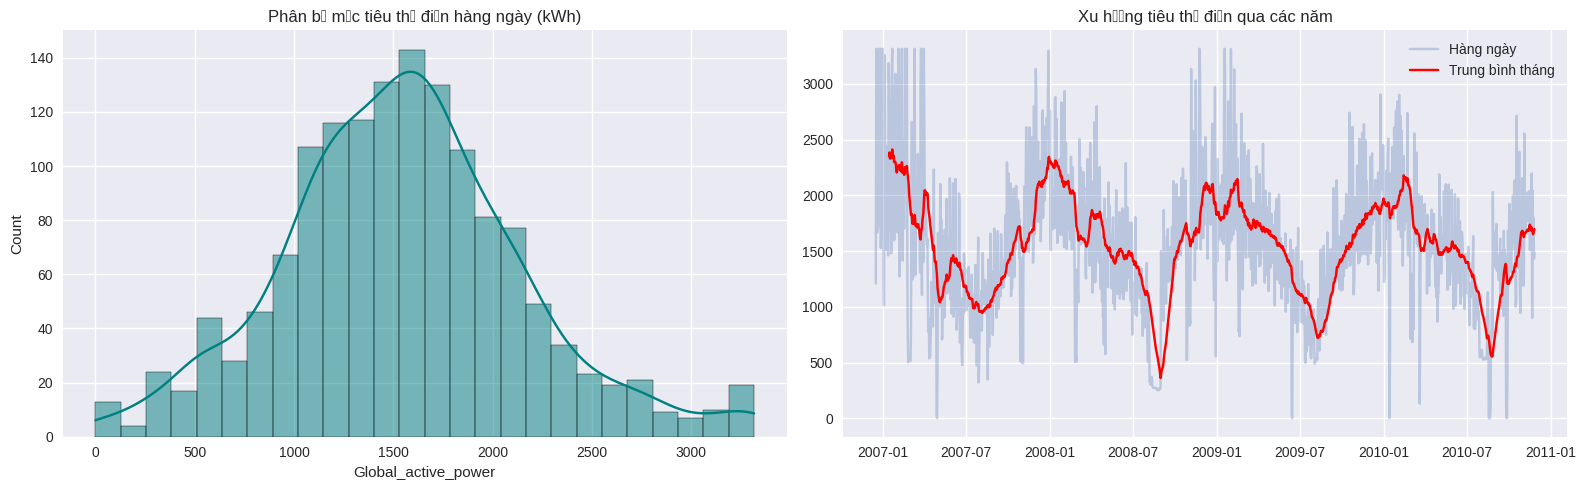

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Biểu đồ 1: Phân bổ tiêu thụ điện
sns.histplot(df_daily['Global_active_power'], kde=True, ax=axes[0], color='teal')
axes[0].set_title('Phân bổ mức tiêu thụ điện hàng ngày (kWh)')

# Biểu đồ 2: Xu hướng dài hạn (Rolling Mean)
axes[1].plot(df_daily['Global_active_power'], alpha=0.3, label='Hàng ngày')
axes[1].plot(df_daily['Global_active_power'].rolling(30).mean(), color='red', label='Trung bình tháng')
axes[1].set_title('Xu hướng tiêu thụ điện qua các năm')
axes[1].legend()

plt.tight_layout()
plt.show()



---
## **3.FEATURE ENGINEERING (KỸ THUẬT ĐẶC TRƯNG)**

---

3.1 Biến đổi chuỗi thời gian thành bài toán Học máy có giám sát.

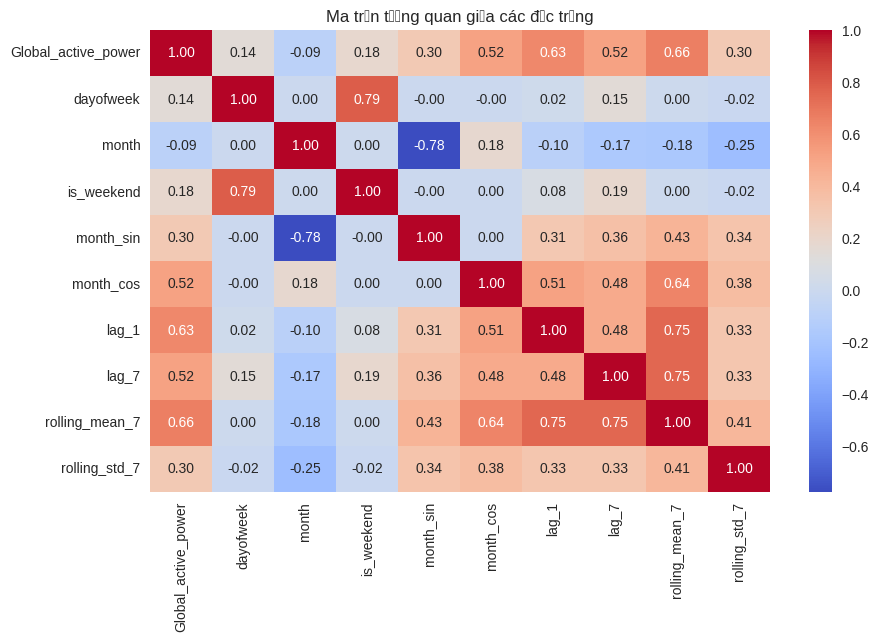

In [66]:
def create_advanced_features(df):
    df = df.copy()
    # Đặc trưng thời gian
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    # Mã hóa chu kỳ (Cyclical Encoding)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Đặc trưng lịch sử (Lags) - Quan trọng nhất trong học có giám sát
    df['lag_1'] = df['Global_active_power'].shift(1)
    df['lag_7'] = df['Global_active_power'].shift(7)

    # Đặc trưng cửa sổ trượt (Rolling)
    df['rolling_mean_7'] = df['Global_active_power'].rolling(window=7).mean().shift(1)
    df['rolling_std_7'] = df['Global_active_power'].rolling(window=7).std().shift(1)

    return df.dropna()

data = create_advanced_features(df_daily)

# Vẽ ma trận tương quan để xem biến nào ảnh hưởng nhất
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Ma trận tương quan giữa các đặc trưng')
plt.show()

## **4. HUẤN LUYỆN VÀ DỰ BÁO CUỐN CHIẾU (RECURSIVE FORECASTING)**

---
4.1. Chia dữ liệu và Chuẩn hóa

---




In [67]:
data = create_advanced_features(df_daily)
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

X_train = train_data.drop('Global_active_power', axis=1)
y_train = train_data['Global_active_power']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)



---

4.2. Workflow Dự báo cuốn chiếu

---



In [68]:

def recursive_forecast(model, scaler_obj, last_30_days_df, steps=30):  # Thêm scaler_obj
    forecasts = []
    temp_df = last_30_days_df.copy()

    for i in range(steps):
        full_features = create_advanced_features(temp_df)
        X_current = full_features.drop('Global_active_power', axis=1).iloc[[-1]]
        X_current_scaled = scaler_obj.transform(X_current)  # Dùng scaler_obj

        pred = model.predict(X_current_scaled)[0]
        pred = max(0, pred)
        forecasts.append(pred)

        next_date = temp_df.index[-1] + pd.Timedelta(days=1)
        new_row = pd.DataFrame({'Global_active_power': [pred]}, index=[next_date])
        temp_df = pd.concat([temp_df, new_row])

    return forecasts

## **5. THỰC NGHIỆM VÀ SO SÁNH 4 MÔ HÌNH**

---

5.1. Chạy mô hình

---



In [95]:
# Sửa đổi tham số để mô hình "hiền" hơn, tránh Overfitting
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=100,
        max_depth=7,        # Giới hạn độ sâu để bớt phức tạp
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
         n_estimators=100,
        learning_rate=0.0067, # Giảm tốc độ học
        max_depth=3,        # Cây nông để bền bỉ hơn khi dự báo xa
        random_state=42
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.00067,
        max_depth=5,          # ← Tăng depth
        subsample=0.8,
        colsample_bytree=0.8, # ← Regularization mạnh hơn
        gamma=0.1,            # ← Min loss reduction
        random_state=42
    )
}
# Lấy ít nhất 31 ngày cuối của tập Train (đủ để tính lag_30 nếu có)
# Đảm bảo history_df là dữ liệu gốc (chưa qua scaler) vì v2 sẽ tự xử lý bên trong
history_df = df_daily.iloc[train_size - 35 : train_size]

actual_30d = test_data['Global_active_power'][:30]

results = {}
for name, model in models.items():
    # Bước 1: Huấn luyện trên toàn bộ tập Train đã chuẩn hóa
    model.fit(X_train_scaled, y_train)

    # Bước 2: Dự báo cuốn chiếu sử dụng hàm v2 (Đảm bảo hàm v2 gọi đúng scaler)
    # Lưu ý: Truyền history_df (gốc) vào để hàm tính toán features đúng quy trình
    results[name] = recursive_forecast(model, scaler, history_df, steps=30)

    print(f"✓ Hoàn thành dự báo tối ưu: {name}")

✓ Hoàn thành dự báo tối ưu: Linear Regression
✓ Hoàn thành dự báo tối ưu: Random Forest
✓ Hoàn thành dự báo tối ưu: Gradient Boosting
✓ Hoàn thành dự báo tối ưu: XGBoost


## **6. TỔNG HỢP VÀ TRỰC QUAN HÓA KẾT QUẢ**

---

6.1. Biểu đồ so sánh sai số tổng tháng (%)

---



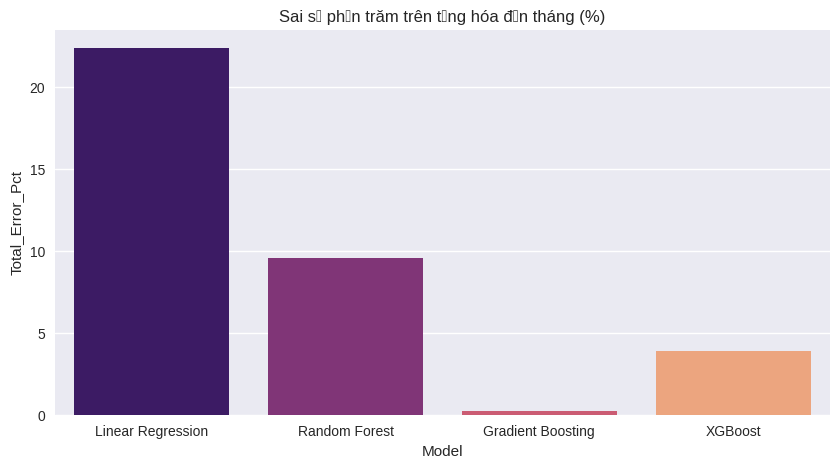

In [96]:
actual_total = actual_30d.sum()
summary = []
for name, preds in results.items():
    err = abs(actual_total - np.sum(preds)) / actual_total * 100
    summary.append({'Model': name, 'Total_Error_Pct': err})

df_summary = pd.DataFrame(summary)
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Total_Error_Pct', data=df_summary, palette='magma')
plt.title('Sai số phần trăm trên tổng hóa đơn tháng (%)')
plt.show()



---
6.2. Trực quan hóa đường dự báo mô hình tốt nhất

---




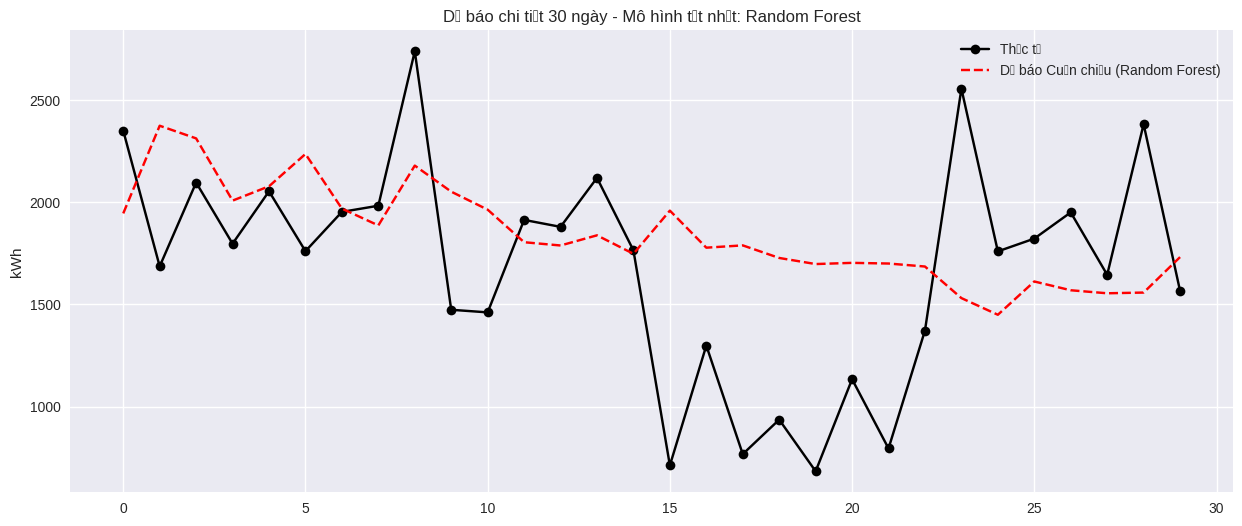

In [72]:
best_m = df_summary.loc[df_summary['Total_Error_Pct'].idxmin(), 'Model']
plt.figure(figsize=(15, 6))
plt.plot(actual_30d.values, label='Thực tế', color='black', marker='o')
plt.plot(results[best_m], label=f'Dự báo Cuốn chiếu ({best_m})', color='red', linestyle='--')
plt.title(f'Dự báo chi tiết 30 ngày - Mô hình tốt nhất: {best_m}')
plt.ylabel('kWh')
plt.legend()
plt.show()